# Problem Statement

This is week 5 of Kaggle's COVID19 forecasting series.

Here we also forecast each country's recovery rate. If forecasted recoveries > forecasted confirmed cases, this means the curve for forecasted confirmedcases have flattened and will be adjusted.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import math
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time

from datetime import timedelta
from sklearn.linear_model import LinearRegression

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/time-series-covid19-recovered-global/time_series_covid19_recovered_global.csv
/kaggle/input/covid19-global-forecasting-week-5/submission.csv
/kaggle/input/covid19-global-forecasting-week-5/test.csv
/kaggle/input/covid19-global-forecasting-week-5/train.csv


In [2]:
N = 3 # Number of previous data points to use to forecast confirmedcases
N_ft = 5 # Number of previous data points to use to forecast fatalities
N_rc = 3 # Number of previous data points to use to forecast recoveries
z_val = 1.645 # For 90% confidence interval

# Common functions

In [3]:
def get_preds_lin_reg(series, pred_min, H):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        series     : series to forecast
        pred_min   : all predictions should be >= pred_min
        H          : forecast horizon
    Outputs
        result: the predictions. The length of result is H. numpy array of shape (H,)
    """
    # Create linear regression object
    regr = LinearRegression(fit_intercept=True)

    pred_list = []

    X_train = np.array(range(len(series))) # e.g. [0 1 2 3 4]
    y_train = np.array(series) # e.g. [2944 3088 3226 3335 3436]
    X_train = X_train.reshape(-1, 1)     # e.g X_train = 
                                             # [[0]
                                             #  [1]
                                             #  [2]
                                             #  [3]
                                             #  [4]]
    # X_train = np.c_[np.ones(N), X_train]              # add a column
    y_train = y_train.reshape(-1, 1)
    regr.fit(X_train, y_train)            # Train the model
    pred = regr.predict(np.array(range(len(series),len(series)+H)).reshape(-1,1))
    pred = pred.reshape(H,)
    
    # If the values are < pred_min, set it to be pred_min
    pred[pred < pred_min] = pred_min
        
    return np.around(pred)

# Load data

In [4]:
train = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-5/train.csv')

# Change column names to lower case
train.columns = [col.lower() for col in train.columns]

# Change to date format
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d')

train

,id,county,province_state,country_region,population,weight,date,target,targetvalue
0,1,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0.0
1,2,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-23,Fatalities,0.0
2,3,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0.0
3,4,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-24,Fatalities,0.0
4,5,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0.0
...,...,...,...,...,...,...,...,...,...
748003,969572,NaN,NaN,Zimbabwe,14240168,0.607106,2020-05-07,Fatalities,0.0
748004,969573,NaN,NaN,Zimbabwe,14240168,0.060711,2020-05-08,ConfirmedCases,0.0
748005,969574,NaN,NaN,Zimbabwe,14240168,0.607106,2020-05-08,Fatalities,0.0
748006,969575,NaN,NaN,Zimbabwe,14240168,0.060711,2020-05-09,ConfirmedCases,1.0


In [5]:
test = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-5/test.csv')

# Change column names to lower case
test.columns = [col.lower() for col in test.columns]

# Change to date format
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')

test

,forecastid,county,province_state,country_region,population,weight,date,target
0,1,NaN,NaN,Afghanistan,27657145,0.058359,2020-04-27,ConfirmedCases
1,2,NaN,NaN,Afghanistan,27657145,0.583587,2020-04-27,Fatalities
2,3,NaN,NaN,Afghanistan,27657145,0.058359,2020-04-28,ConfirmedCases
3,4,NaN,NaN,Afghanistan,27657145,0.583587,2020-04-28,Fatalities
4,5,NaN,NaN,Afghanistan,27657145,0.058359,2020-04-29,ConfirmedCases
...,...,...,...,...,...,...,...,...
311665,311666,NaN,NaN,Zimbabwe,14240168,0.607106,2020-06-08,Fatalities
311666,311667,NaN,NaN,Zimbabwe,14240168,0.060711,2020-06-09,ConfirmedCases
311667,311668,NaN,NaN,Zimbabwe,14240168,0.607106,2020-06-09,Fatalities
311668,311669,NaN,NaN,Zimbabwe,14240168,0.060711,2020-06-10,ConfirmedCases


In [6]:
submission = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-5/submission.csv')
submission

,ForecastId_Quantile,TargetValue
0,1_0.05,1
1,1_0.5,1
2,1_0.95,1
3,2_0.05,1
4,2_0.5,1
...,...,...
935005,311669_0.5,1
935006,311669_0.95,1
935007,311670_0.05,1
935008,311670_0.5,1


# Load recoveries data

In [7]:
# Get recovery data
# url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
# recov = pd.read_csv(url, error_bad_lines=False)

recov = pd.read_csv('../input/time-series-covid19-recovered-global/time_series_covid19_recovered_global.csv')
recov

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,260,310,331,345,397,421,458,468,472,502
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,470,488,519,531,543,570,595,605,620,627
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,1779,1821,1872,1936,1998,2067,2197,2323,2467,2546
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,468,468,472,493,499,514,521,526,537,545
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,7,11,11,11,11,11,11,11,11,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,5,5,5,5,5,5,5,5,5,5
248,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4
249,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
250,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Convert recoveries to the right format
province_state = []
country_region = []
date = []
recoveries = []

dates = list(recov.columns[4:])
for index, row in recov.iterrows():
    province_state = province_state + [row['Province/State']]*len(dates)
    country_region = country_region + [row['Country/Region']]*len(dates)
    date = date + dates
    recoveries = recoveries + list(row[4:])
    
recoveries_df = pd.DataFrame({'province_state': province_state,
                              'country_region': country_region,
                              'date': date,
                              'recoveries_tot': recoveries})

# Change to date format
recoveries_df['date'] = pd.to_datetime(recoveries_df['date'], format='%m/%d/%y')

# Add a column 'county'
recoveries_df['county'] = 'nil'

# Change NaN to nil
recoveries_df['province_state'] = recoveries_df['province_state'].fillna(value = 'nil')

recoveries_df

,province_state,country_region,date,recoveries_tot,county
0,nil,Afghanistan,2020-01-22,0,nil
1,nil,Afghanistan,2020-01-23,0,nil
2,nil,Afghanistan,2020-01-24,0,nil
3,nil,Afghanistan,2020-01-25,0,nil
4,nil,Afghanistan,2020-01-26,0,nil
...,...,...,...,...,...
27463,nil,Tajikistan,2020-05-05,0,nil
27464,nil,Tajikistan,2020-05-06,0,nil
27465,nil,Tajikistan,2020-05-07,0,nil
27466,nil,Tajikistan,2020-05-08,0,nil


# EDA

In [9]:
# Count number of nulls for each column
train.isnull().sum(axis=0)

id                    0
county            69120
province_state    40392
country_region        0
population            0
weight                0
date                  0
target                0
targetvalue           0
dtype: int64

In [10]:
# Count number of nulls for each column
recoveries_df.isnull().sum(axis=0)

province_state    0
country_region    0
date              0
recoveries_tot    0
county            0
dtype: int64

In [11]:
# Get the counties
print(len(train['county'].unique()))
print(train['county'].unique().tolist())

1841
[nan, 'Autauga', 'Baldwin', 'Barbour', 'Bibb', 'Blount', 'Bullock', 'Butler', 'Calhoun', 'Chambers', 'Cherokee', 'Chilton', 'Choctaw', 'Clarke', 'Clay', 'Cleburne', 'Coffee', 'Colbert', 'Conecuh', 'Coosa', 'Covington', 'Crenshaw', 'Cullman', 'Dale', 'Dallas', 'DeKalb', 'Elmore', 'Escambia', 'Etowah', 'Fayette', 'Franklin', 'Geneva', 'Greene', 'Hale', 'Henry', 'Houston', 'Jackson', 'Jefferson', 'Lamar', 'Lauderdale', 'Lawrence', 'Lee', 'Limestone', 'Lowndes', 'Macon', 'Madison', 'Marengo', 'Marion', 'Marshall', 'Mobile', 'Monroe', 'Montgomery', 'Morgan', 'Perry', 'Pickens', 'Pike', 'Randolph', 'Russell', 'Shelby', 'St. Clair', 'Sumter', 'Talladega', 'Tallapoosa', 'Tuscaloosa', 'Walker', 'Washington', 'Wilcox', 'Winston', 'Aleutians East', 'Aleutians West', 'Anchorage', 'Bethel', 'Bristol Bay', 'Denali', 'Dillingham', 'Fairbanks North Star', 'Haines', 'Hoonah-Angoon', 'Juneau', 'Kenai Peninsula', 'Ketchikan Gateway', 'Kodiak Island', 'Kusilvak', 'Lake and Peninsula', 'Matanuska-Susi

In [12]:
# Get the province_states
print(len(train['province_state'].unique()))
train['province_state'].unique()

134


array([nan, 'Australian Capital Territory', 'New South Wales',
       'Northern Territory', 'Queensland', 'South Australia', 'Tasmania',
       'Victoria', 'Western Australia', 'Alberta', 'British Columbia',
       'Manitoba', 'New Brunswick', 'Newfoundland and Labrador',
       'Northwest Territories', 'Nova Scotia', 'Ontario',
       'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Yukon', 'Anhui',
       'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong', 'Guangxi',
       'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan', 'Hong Kong',
       'Hubei', 'Hunan', 'Inner Mongolia', 'Jiangsu', 'Jiangxi', 'Jilin',
       'Liaoning', 'Macau', 'Ningxia', 'Qinghai', 'Shaanxi', 'Shandong',
       'Shanghai', 'Shanxi', 'Sichuan', 'Tianjin', 'Tibet', 'Xinjiang',
       'Yunnan', 'Zhejiang', 'Faroe Islands', 'Greenland',
       'French Guiana', 'French Polynesia', 'Guadeloupe', 'Martinique',
       'Mayotte', 'New Caledonia', 'Reunion', 'Saint Barthelemy',
       'Saint Pierre and Miqu

In [13]:
# Get the country_regions
print(len(train['country_region'].unique()))
train['country_region'].unique()

187


array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guin

In [14]:
# Get amount of data per country
train['country_region'].value_counts()

US                690768
China               7344
Canada              2808
France              2376
United Kingdom      2376
                   ...  
Montenegro           216
Burma                216
Tanzania             216
Haiti                216
Sierra Leone         216
Name: country_region, Length: 187, dtype: int64

In [15]:
train[train['country_region']=='Singapore']

,id,county,province_state,country_region,population,weight,date,target,targetvalue
47520,61601,NaN,NaN,Singapore,5535000,0.064406,2020-01-23,ConfirmedCases,1.0
47521,61602,NaN,NaN,Singapore,5535000,0.644056,2020-01-23,Fatalities,0.0
47522,61603,NaN,NaN,Singapore,5535000,0.064406,2020-01-24,ConfirmedCases,2.0
47523,61604,NaN,NaN,Singapore,5535000,0.644056,2020-01-24,Fatalities,0.0
47524,61605,NaN,NaN,Singapore,5535000,0.064406,2020-01-25,ConfirmedCases,0.0
...,...,...,...,...,...,...,...,...,...
47731,61812,NaN,NaN,Singapore,5535000,0.644056,2020-05-07,Fatalities,0.0
47732,61813,NaN,NaN,Singapore,5535000,0.064406,2020-05-08,ConfirmedCases,768.0
47733,61814,NaN,NaN,Singapore,5535000,0.644056,2020-05-08,Fatalities,0.0
47734,61815,NaN,NaN,Singapore,5535000,0.064406,2020-05-09,ConfirmedCases,753.0


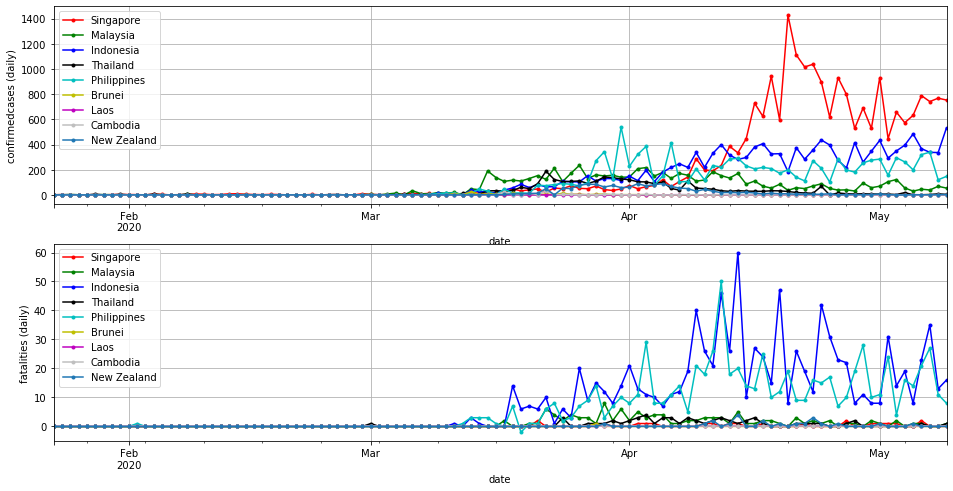

In [16]:
# Plot the confirmed cases (daily) and fatalities (daily) in SEA
countries_list = ['Singapore', 'Malaysia', 'Indonesia', 'Thailand', 'Philippines', 'Brunei', 'Laos', 'Cambodia', 'New Zealand']
color_list = ['r', 'g', 'b', 'k', 'c', 'y', 'm', '0.75', 'tab:blue']

fig, axes = plt.subplots(2,1)
ax = train[(train['country_region']==countries_list[0]) & (train['target']=='ConfirmedCases') & (train['county'].isnull()) & (train['province_state'].isnull())].plot(ax=axes[0], x='date', y='targetvalue', color=color_list[0], marker='.', grid=True, figsize=(16, 8))
ax1 = train[(train['country_region']==countries_list[0]) & (train['target']=='Fatalities') & (train['county'].isnull()) & (train['province_state'].isnull())].plot(ax=axes[1], x='date', y='targetvalue', color=color_list[0], marker='.', grid=True)

i = 1
for country in countries_list[1:]:
    ax = train[(train['country_region']==country) & (train['target']=='ConfirmedCases') & (train['county'].isnull()) & (train['province_state'].isnull())].plot(x='date', y='targetvalue', color=color_list[i%len(color_list)], marker='.', grid=True, ax=ax)
    ax1 = train[(train['country_region']==country) & (train['target']=='Fatalities') & (train['county'].isnull()) & (train['province_state'].isnull())].plot(x='date', y='targetvalue', color=color_list[i%len(color_list)], marker='.', grid=True, ax=ax1)
    i = i + 1
    
ax.set_xlabel("date")
ax.set_ylabel("confirmedcases (daily)")
ax.legend(countries_list, loc=2)

ax1.set_xlabel("date")
ax1.set_ylabel("fatalities (daily)")
ax1.legend(countries_list, loc=2)

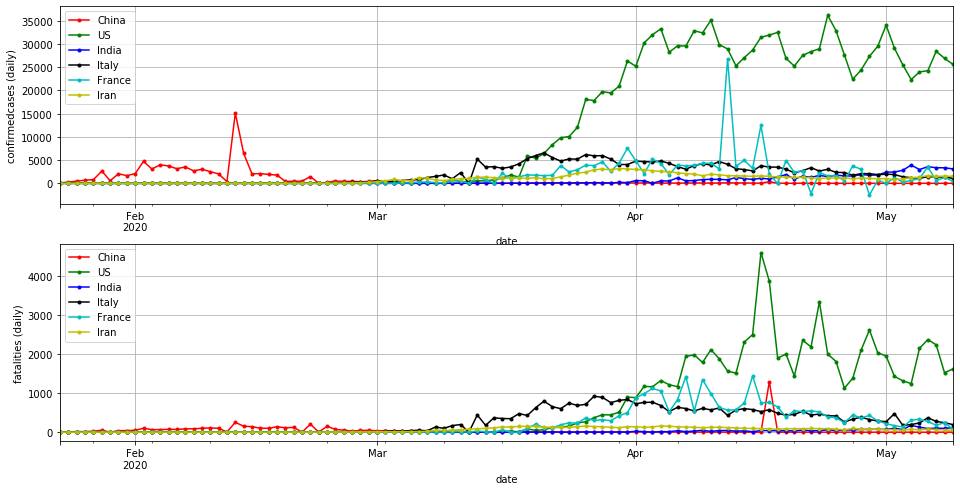

In [17]:
# Plot the confirmed cases (daily) and fatalities (daily) in big countries
countries_list = ['China', 'US', 'India', 'Italy', 'France', 'Iran']
color_list = ['r', 'g', 'b', 'k', 'c', 'y', 'm', '0.75', 'tab:blue']

fig, axes = plt.subplots(2,1)
ax = train[(train['country_region']==countries_list[0]) & (train['target']=='ConfirmedCases') & (train['county'].isnull()) & (train['province_state'].isnull())].plot(ax=axes[0], x='date', y='targetvalue', color=color_list[0], marker='.', grid=True, figsize=(16, 8))
ax1 = train[(train['country_region']==countries_list[0]) & (train['target']=='Fatalities') & (train['county'].isnull()) & (train['province_state'].isnull())].plot(ax=axes[1], x='date', y='targetvalue', color=color_list[0], marker='.', grid=True)

i = 1
for country in countries_list[1:]:
    ax = train[(train['country_region']==country) & (train['target']=='ConfirmedCases') & (train['county'].isnull()) & (train['province_state'].isnull())].plot(x='date', y='targetvalue', color=color_list[i%len(color_list)], marker='.', grid=True, ax=ax)
    ax1 = train[(train['country_region']==country) & (train['target']=='Fatalities') & (train['county'].isnull()) & (train['province_state'].isnull())].plot(x='date', y='targetvalue', color=color_list[i%len(color_list)], marker='.', grid=True, ax=ax1)
    i = i + 1
    
ax.set_xlabel("date")
ax.set_ylabel("confirmedcases (daily)")
ax.legend(countries_list, loc=2)

ax1.set_xlabel("date")
ax1.set_ylabel("fatalities (daily)")
ax1.legend(countries_list, loc=2)

Why are there negative values in the targetvalues?

# Pre-process train, test

In [18]:
# Fill nans in province_state and county with ''
train['province_state'] = train['province_state'].fillna(value = 'nil')
train['county'] = train['county'].fillna(value = 'nil')
test['province_state'] = test['province_state'].fillna(value = 'nil')
test['county'] = test['county'].fillna(value = 'nil')

In [19]:
# Get unique combinations of province_state and country_region
ct_ps_cr_unique = train[['county', 'province_state', 'country_region']].drop_duplicates()
ct_ps_cr_unique

,county,province_state,country_region
0,nil,nil,Afghanistan
216,nil,nil,Albania
432,nil,nil,Algeria
648,nil,nil,Andorra
864,nil,nil,Angola
...,...,...,...
746928,nil,nil,West Bank and Gaza
747144,nil,nil,Western Sahara
747360,nil,nil,Yemen
747576,nil,nil,Zambia


In [20]:
# Get number of days we need to predict
date_max_train = train[(train['province_state']=='nil') & 
                       (train['county']=='nil') & 
                       (train['country_region']=='Singapore')]['date'].max()

date_max_test = test[(test['province_state']=='nil') &
                     (test['county']=='nil') &
                     (test['country_region']=='Singapore')]['date'].max()

pred_days = (date_max_test - date_max_train).days
print(date_max_train, date_max_test, pred_days)

2020-05-09 00:00:00 2020-06-10 00:00:00 32


In [21]:
# Split train set
train_cc = train[train['target']=='ConfirmedCases']
train_ft = train[train['target']=='Fatalities']
train_cc

,id,county,province_state,country_region,population,weight,date,target,targetvalue
0,1,nil,nil,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0.0
2,3,nil,nil,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0.0
4,5,nil,nil,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0.0
6,7,nil,nil,Afghanistan,27657145,0.058359,2020-01-26,ConfirmedCases,0.0
8,9,nil,nil,Afghanistan,27657145,0.058359,2020-01-27,ConfirmedCases,0.0
...,...,...,...,...,...,...,...,...,...
747998,969567,nil,nil,Zimbabwe,14240168,0.060711,2020-05-05,ConfirmedCases,0.0
748000,969569,nil,nil,Zimbabwe,14240168,0.060711,2020-05-06,ConfirmedCases,0.0
748002,969571,nil,nil,Zimbabwe,14240168,0.060711,2020-05-07,ConfirmedCases,0.0
748004,969573,nil,nil,Zimbabwe,14240168,0.060711,2020-05-08,ConfirmedCases,0.0


In [22]:
# Do cumsum to get total cases
tic = time.time()
train_cc_tot = train_cc[(train_cc['county']==ct_ps_cr_unique.iloc[0]['county']) & 
                          (train_cc['province_state']==ct_ps_cr_unique.iloc[0]['province_state']) & 
                          (train_cc['country_region']==ct_ps_cr_unique.iloc[0]['country_region'])].copy()
train_cc_tot.loc[:, 'targetvalue_tot'] = train_cc_tot['targetvalue'].cumsum()

train_ft_tot = train_ft[(train_ft['county']==ct_ps_cr_unique.iloc[0]['county']) & 
                          (train_ft['province_state']==ct_ps_cr_unique.iloc[0]['province_state']) & 
                          (train_ft['country_region']==ct_ps_cr_unique.iloc[0]['country_region'])].copy()
train_ft_tot.loc[:, 'targetvalue_tot'] = train_ft_tot['targetvalue'].cumsum()

for index, row in ct_ps_cr_unique[1:].iterrows():
    train_cc_temp = train_cc[(train_cc['county']==row['county']) & 
                          (train_cc['province_state']==row['province_state']) & 
                          (train_cc['country_region']==row['country_region'])].copy()
    train_cc_temp.loc[:, 'targetvalue_tot'] = train_cc_temp['targetvalue'].cumsum()
    train_cc_tot = pd.concat([train_cc_tot, train_cc_temp], axis=0)
    
    train_ft_temp = train_ft[(train_ft['county']==row['county']) & 
                          (train_ft['province_state']==row['province_state']) & 
                          (train_ft['country_region']==row['country_region'])].copy()
    train_ft_temp.loc[:, 'targetvalue_tot'] = train_ft_temp['targetvalue'].cumsum()
    train_ft_tot = pd.concat([train_ft_tot, train_ft_temp], axis=0)

toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")
train_cc_tot

Time taken = 26.048584818840027 mins


,id,county,province_state,country_region,population,weight,date,target,targetvalue,targetvalue_tot
0,1,nil,nil,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0.0,0.0
2,3,nil,nil,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0.0,0.0
4,5,nil,nil,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0.0,0.0
6,7,nil,nil,Afghanistan,27657145,0.058359,2020-01-26,ConfirmedCases,0.0,0.0
8,9,nil,nil,Afghanistan,27657145,0.058359,2020-01-27,ConfirmedCases,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
747998,969567,nil,nil,Zimbabwe,14240168,0.060711,2020-05-05,ConfirmedCases,0.0,34.0
748000,969569,nil,nil,Zimbabwe,14240168,0.060711,2020-05-06,ConfirmedCases,0.0,34.0
748002,969571,nil,nil,Zimbabwe,14240168,0.060711,2020-05-07,ConfirmedCases,0.0,34.0
748004,969573,nil,nil,Zimbabwe,14240168,0.060711,2020-05-08,ConfirmedCases,0.0,34.0


In [23]:
# Merge recoveries_df with train
train_cc_tot_merged = train_cc_tot.merge(recoveries_df,
                           left_on=['county', 'province_state', 'country_region', 'date'], 
                           right_on=['county', 'province_state', 'country_region', 'date'], 
                           how='left')
train_cc_tot_merged

,id,county,province_state,country_region,population,weight,date,target,targetvalue,targetvalue_tot,recoveries_tot
0,1,nil,nil,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0.0,0.0,0.0
1,3,nil,nil,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0.0,0.0,0.0
2,5,nil,nil,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0.0,0.0,0.0
3,7,nil,nil,Afghanistan,27657145,0.058359,2020-01-26,ConfirmedCases,0.0,0.0,0.0
4,9,nil,nil,Afghanistan,27657145,0.058359,2020-01-27,ConfirmedCases,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
373999,969567,nil,nil,Zimbabwe,14240168,0.060711,2020-05-05,ConfirmedCases,0.0,34.0,5.0
374000,969569,nil,nil,Zimbabwe,14240168,0.060711,2020-05-06,ConfirmedCases,0.0,34.0,5.0
374001,969571,nil,nil,Zimbabwe,14240168,0.060711,2020-05-07,ConfirmedCases,0.0,34.0,5.0
374002,969573,nil,nil,Zimbabwe,14240168,0.060711,2020-05-08,ConfirmedCases,0.0,34.0,9.0


In [24]:
# Count number of nulls for each column
train_cc_tot_merged.isnull().sum(axis=0)

id                      0
county                  0
province_state          0
country_region          0
population              0
weight                  0
date                    0
target                  0
targetvalue             0
targetvalue_tot         0
recoveries_tot     346788
dtype: int64

In [25]:
# Fill recoveries nans with 0
train_cc_tot_merged['recoveries_tot'] = train_cc_tot_merged['recoveries_tot'].fillna(value = 0)

# Prediction for one country

In [26]:
# # Specify the country here
# ct = 'nil'
# ps = 'nil'
# cr = 'Singapore'

In [27]:
# train_sgp = train_cc_tot[(train_cc_tot['county']==ct) & (train_cc_tot['province_state']==ps) & (train_cc_tot['country_region']==cr)]
# train_sgp[-5:]

In [28]:
# # Get predictions 
# preds = get_preds_lin_reg(train_sgp['targetvalue_tot'][-N:], 0, pred_days)
# preds

In [29]:
# # Put into dataframe
# date_list = []
# date = pd.date_range(date_max_train+timedelta(days=1), date_max_test)
# results = pd.DataFrame({'date': date, 'preds':preds})
# results.head()

In [30]:
# # Plot the confirmed cases in Singapore and the predictions
# ax = train_cc_tot[(train_cc_tot['county']==ct) & (train_cc_tot['province_state']==ps) & (train_cc_tot['country_region']==cr)].plot(x='date', y='targetvalue_tot', style = 'r.-', grid=True, figsize=(10, 6))
# ax = results.plot(x='date', y='preds', style = 'r.', grid=True, figsize=(10, 6), ax=ax)
    

# ax.set_xlabel("date")
# ax.set_ylabel("confirmed cases total")
# ax.legend([cr])

# Predictions for confirmedcases, fatalities, recoveries

In [31]:
ct_list = []
ps_list = []
cr_list = []
date_list = []
confirmedcasespred_list = []
fatalities_list = []
recoveries_list = []

tic = time.time()
for index, row in ct_ps_cr_unique.iterrows():
    train_cc_temp = train_cc_tot[(train_cc_tot['county']==row['county']) &
                                 (train_cc_tot['province_state']==row['province_state']) & 
                                 (train_cc_tot['country_region']==row['country_region'])]
    preds = get_preds_lin_reg(train_cc_temp['targetvalue_tot'][-N:], 0, pred_days)
    confirmedcasespred_list = confirmedcasespred_list + list(preds)
    
    train_ft_temp = train_ft_tot[(train_ft_tot['county']==row['county']) &
                                 (train_ft_tot['province_state']==row['province_state']) & 
                                 (train_ft_tot['country_region']==row['country_region'])]
    preds = get_preds_lin_reg(train_ft_temp['targetvalue_tot'][-N_ft:], 0, pred_days)
    fatalities_list = fatalities_list + list(preds)
    
    train_cc_temp = train_cc_tot_merged[(train_cc_tot_merged['county']==row['county']) &
                                        (train_cc_tot_merged['province_state']==row['province_state']) & 
                                        (train_cc_tot_merged['country_region']==row['country_region'])]
    preds = get_preds_lin_reg(train_cc_temp['targetvalue_tot'][-N_rc:], 0, pred_days)
    recoveries_list = recoveries_list + list(preds)
    
    ct_list = ct_list + ([row['county']]*pred_days)
    ps_list = ps_list + ([row['province_state']]*pred_days)
    cr_list = cr_list + ([row['country_region']]*pred_days)
    date_list = date_list + list(pd.date_range(date_max_train+timedelta(days=1), date_max_test).strftime("%Y-%m-%d"))
    

results = pd.DataFrame({'county': ct_list,
                        'province_state': ps_list,
                        'country_region': cr_list,
                        'date': date_list,
                        'confirmedcases_tot': confirmedcasespred_list, 
                        'fatalities_tot': fatalities_list,
                        'recoveries_tot': recoveries_list})
results['date'] = pd.to_datetime(results['date'], format='%Y-%m-%d')

toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")
results

Time taken = 32.88114481767018 mins


,county,province_state,country_region,date,confirmedcases_tot,fatalities_tot,recoveries_tot
0,nil,nil,Afghanistan,2020-05-10,4261.0,119.0,4261.0
1,nil,nil,Afghanistan,2020-05-11,4496.0,124.0,4496.0
2,nil,nil,Afghanistan,2020-05-12,4731.0,128.0,4731.0
3,nil,nil,Afghanistan,2020-05-13,4966.0,133.0,4966.0
4,nil,nil,Afghanistan,2020-05-14,5201.0,137.0,5201.0
...,...,...,...,...,...,...,...
110811,nil,nil,Zimbabwe,2020-06-06,49.0,4.0,49.0
110812,nil,nil,Zimbabwe,2020-06-07,49.0,4.0,49.0
110813,nil,nil,Zimbabwe,2020-06-08,50.0,4.0,50.0
110814,nil,nil,Zimbabwe,2020-06-09,50.0,4.0,50.0


In [32]:
# Get rows where recoveries > confirmedcases
x = results[results['recoveries_tot'] > results['confirmedcases_tot']]
print(x.to_string())

Empty DataFrame
Columns: [county, province_state, country_region, date, confirmedcases_tot, fatalities_tot, recoveries_tot]
Index: []


In [33]:
# For each country, if recoveries > confirmedcases, confirmedcases should stop increasing.
# e.g.
# province          country     date        confirmedcases     fatalities      recoveries
# South Australia	Australia	2020-04-20	439.0              4.0             425.0
# South Australia	Australia	2020-04-21	440.0              4.0             460.0
# South Australia	Australia	2020-04-22	441.0              4.0             494.0
# should become
# province          country     date        confirmedcases     fatalities      recoveries
# South Australia	Australia	2020-04-20	439.0              4.0             425.0
# South Australia	Australia	2020-04-21	440.0              4.0             460.0
# South Australia	Australia	2020-04-22	440.0              4.0             494.0       # here confirmedcases stopped increasing
def confirmedcases_stop(df):
    # Check if any rows where recoveries > confirmedcases
    if len(df[df['recoveries_tot']>df['confirmedcases_tot']])==0:
        return df
    else:
        # Extract the confirmedcases at the date where recoveries > confirmedcases
        confirmedcases_sat = df[df['recoveries_tot']>df['confirmedcases_tot']]['confirmedcases_tot'].iloc[0]
        
        # For all rows where recoveries > confirmedcases, set confirmedcases = confirmedcases_max
        df.loc[df['recoveries_tot']>df['confirmedcases_tot'], 'confirmedcases_tot'] = confirmedcases_sat
        
        return df

temp = results[(results['county']==ct_ps_cr_unique.iloc[0]['county']) & 
               (results['province_state']==ct_ps_cr_unique.iloc[0]['province_state']) & 
               (results['country_region']==ct_ps_cr_unique.iloc[0]['country_region'])].copy()
results_sat = confirmedcases_stop(temp)
    
tic = time.time()
for index, row in ct_ps_cr_unique[1:].iterrows():
    temp = results[(results['county']==row['county']) & 
                   (results['province_state']==row['province_state']) & 
                   (results['country_region']==row['country_region'])].copy()
    ps_cr_df = confirmedcases_stop(temp)
    results_sat = pd.concat([results_sat, ps_cr_df], axis=0) 
toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")
    
results_sat

Time taken = 3.462701956431071 mins


,county,province_state,country_region,date,confirmedcases_tot,fatalities_tot,recoveries_tot
0,nil,nil,Afghanistan,2020-05-10,4261.0,119.0,4261.0
1,nil,nil,Afghanistan,2020-05-11,4496.0,124.0,4496.0
2,nil,nil,Afghanistan,2020-05-12,4731.0,128.0,4731.0
3,nil,nil,Afghanistan,2020-05-13,4966.0,133.0,4966.0
4,nil,nil,Afghanistan,2020-05-14,5201.0,137.0,5201.0
...,...,...,...,...,...,...,...
110811,nil,nil,Zimbabwe,2020-06-06,49.0,4.0,49.0
110812,nil,nil,Zimbabwe,2020-06-07,49.0,4.0,49.0
110813,nil,nil,Zimbabwe,2020-06-08,50.0,4.0,50.0
110814,nil,nil,Zimbabwe,2020-06-09,50.0,4.0,50.0


In [34]:
train_cc_tot

,id,county,province_state,country_region,population,weight,date,target,targetvalue,targetvalue_tot
0,1,nil,nil,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0.0,0.0
2,3,nil,nil,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0.0,0.0
4,5,nil,nil,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0.0,0.0
6,7,nil,nil,Afghanistan,27657145,0.058359,2020-01-26,ConfirmedCases,0.0,0.0
8,9,nil,nil,Afghanistan,27657145,0.058359,2020-01-27,ConfirmedCases,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
747998,969567,nil,nil,Zimbabwe,14240168,0.060711,2020-05-05,ConfirmedCases,0.0,34.0
748000,969569,nil,nil,Zimbabwe,14240168,0.060711,2020-05-06,ConfirmedCases,0.0,34.0
748002,969571,nil,nil,Zimbabwe,14240168,0.060711,2020-05-07,ConfirmedCases,0.0,34.0
748004,969573,nil,nil,Zimbabwe,14240168,0.060711,2020-05-08,ConfirmedCases,0.0,34.0


In [35]:
# Get daily ConfirmedCases, Fatalities
results_sat_daily = pd.DataFrame()

for index, row in ct_ps_cr_unique.iterrows():
    temp = results_sat[(results_sat['county']==row['county']) & 
                   (results_sat['province_state']==row['province_state']) & 
                   (results_sat['country_region']==row['country_region'])].copy()
    
    temp['ConfirmedCases'] = temp['confirmedcases_tot'].diff()
    temp['Fatalities'] = temp['fatalities_tot'].diff()
    
    # Get first value for ConfirmedCases
    train_cc_temp = train_cc_tot[(train_cc_tot['county']==row['county']) &
                                 (train_cc_tot['province_state']==row['province_state']) & 
                                 (train_cc_tot['country_region']==row['country_region'])]    
    temp.loc[temp.index[0], 'ConfirmedCases'] = temp.loc[temp.index[0], 'confirmedcases_tot'] - \
                                                train_cc_temp.loc[train_cc_temp.index[-1], 'targetvalue_tot']
    
    # Get first value for Fatalities
    train_ft_temp = train_ft_tot[(train_ft_tot['county']==row['county']) &
                                 (train_ft_tot['province_state']==row['province_state']) & 
                                 (train_ft_tot['country_region']==row['country_region'])]    
    temp.loc[temp.index[0], 'Fatalities'] = temp.loc[temp.index[0], 'fatalities_tot'] - \
                                                train_ft_temp.loc[train_ft_temp.index[-1], 'targetvalue_tot']
    
    results_sat_daily = results_sat_daily.append(temp)
    
results_sat_daily

,county,province_state,country_region,date,confirmedcases_tot,fatalities_tot,recoveries_tot,ConfirmedCases,Fatalities
0,nil,nil,Afghanistan,2020-05-10,4261.0,119.0,4261.0,228.0,4.0
1,nil,nil,Afghanistan,2020-05-11,4496.0,124.0,4496.0,235.0,5.0
2,nil,nil,Afghanistan,2020-05-12,4731.0,128.0,4731.0,235.0,4.0
3,nil,nil,Afghanistan,2020-05-13,4966.0,133.0,4966.0,235.0,5.0
4,nil,nil,Afghanistan,2020-05-14,5201.0,137.0,5201.0,235.0,4.0
...,...,...,...,...,...,...,...,...,...
110811,nil,nil,Zimbabwe,2020-06-06,49.0,4.0,49.0,1.0,0.0
110812,nil,nil,Zimbabwe,2020-06-07,49.0,4.0,49.0,0.0,0.0
110813,nil,nil,Zimbabwe,2020-06-08,50.0,4.0,50.0,1.0,0.0
110814,nil,nil,Zimbabwe,2020-06-09,50.0,4.0,50.0,0.0,0.0


# Get std dev of the predictions for confirmedcases, fatalities, recoveries

In [36]:
# Use 20% of train_cc_tot to calculate the std dev of the pred error
date_max_train = train[(train['province_state']=='nil') & 
                       (train['county']=='nil') & 
                       (train['country_region']=='Singapore')]['date'].max()

date_min_train = train[(train['province_state']=='nil') &
                     (train['county']=='nil') &
                     (train['country_region']=='Singapore')]['date'].min()

diff_days = (date_max_train - date_min_train).days
train_size = int(0.8*diff_days)
val_size = diff_days - train_size
train_size, val_size

(85, 22)

In [37]:
def saturate(cc, rc):
    """
    If rc > cc, then cc should saturate
    e.g.
    cc = np.array([1, 2, 3])
    rc = np.array([1, 3, 4])
    Return np.array([1, 2, 2])
    """
    if sum(rc>cc)==0:
        return cc
    else:
        sat_value = rc[np.argmax((rc>cc)==True)]
        cc[rc>cc] = sat_value
        return cc
    

In [38]:
ct_list = []
ps_list = []
cr_list = []
cc_stddev_list = []
ft_stddev_list = []

tic = time.time()
for index, row in ct_ps_cr_unique.iterrows():
    # Predict confirmedcases
    train_cc_tr = train_cc_tot[(train_cc_tot['county']==row['county']) &
                               (train_cc_tot['province_state']==row['province_state']) & 
                               (train_cc_tot['country_region']==row['country_region'])][:train_size]
    train_cc_val = train_cc_tot[(train_cc_tot['county']==row['county']) &
                                (train_cc_tot['province_state']==row['province_state']) & 
                                (train_cc_tot['country_region']==row['country_region'])][train_size:]
    preds = get_preds_lin_reg(train_cc_tr['targetvalue_tot'][-N:], 0, len(train_cc_val))
    
    # Predict recoveries
    train_cc_tr = train_cc_tot_merged[(train_cc_tot_merged['county']==row['county']) &
                               (train_cc_tot_merged['province_state']==row['province_state']) & 
                               (train_cc_tot_merged['country_region']==row['country_region'])][:train_size]
    preds_recov = get_preds_lin_reg(train_cc_tr['recoveries_tot'][-N_rc:], 0, len(train_cc_val))
    preds = saturate(preds, preds_recov)
    cc_stddev_list = cc_stddev_list + [np.std(preds - train_cc_val['targetvalue_tot'])]

    # Predict fatalities
    train_ft_tr = train_ft_tot[(train_ft_tot['county']==row['county']) &
                               (train_ft_tot['province_state']==row['province_state']) & 
                               (train_ft_tot['country_region']==row['country_region'])][:train_size]
    train_ft_val = train_ft_tot[(train_ft_tot['county']==row['county']) &
                                (train_ft_tot['province_state']==row['province_state']) & 
                                (train_ft_tot['country_region']==row['country_region'])][train_size:]
    preds = get_preds_lin_reg(train_ft_tr['targetvalue_tot'][-N_ft:], 0, len(train_ft_val))
    ft_stddev_list = ft_stddev_list + [np.std(preds - train_ft_val['targetvalue_tot'])]

    ct_list = ct_list + [row['county']]
    ps_list = ps_list + [row['province_state']]
    cr_list = cr_list + [row['country_region']]
    

results = pd.DataFrame({'county': ct_list,
                        'province_state': ps_list,
                        'country_region': cr_list,
                        'cc_stddev': cc_stddev_list, 
                        'ft_stddev': ft_stddev_list})
toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")
results

Time taken = 52.5411962668101 mins


,county,province_state,country_region,cc_stddev,ft_stddev
0,nil,nil,Afghanistan,578.530042,9.897012
1,nil,nil,Albania,49.210055,3.386284
2,nil,nil,Algeria,312.794508,49.741639
3,nil,nil,Andorra,31.470693,3.954849
4,nil,nil,Angola,6.364778,0.000000
...,...,...,...,...,...
3458,nil,nil,West Bank and Gaza,15.085014,0.000000
3459,nil,nil,Western Sahara,0.000000,0.000000
3460,nil,nil,Yemen,10.897356,2.295718
3461,nil,nil,Zambia,35.704469,0.930475


# Get 90% confidence intervals of the predictions

In [39]:
results_sat_daily_ci = pd.DataFrame()

tic = time.time()
for index, row in ct_ps_cr_unique.iterrows():
    temp = results_sat_daily[(results_sat_daily['county']==row['county']) & 
                             (results_sat_daily['province_state']==row['province_state']) & 
                             (results_sat_daily['country_region']==row['country_region'])].copy()
    
    cc_stddev = results[(results['county']==row['county']) & 
                        (results['province_state']==row['province_state']) & 
                        (results['country_region']==row['country_region'])]['cc_stddev']
    
    ft_stddev = results[(results['county']==row['county']) & 
                        (results['province_state']==row['province_state']) & 
                        (results['country_region']==row['country_region'])]['ft_stddev']
    
    results_sat_daily_ci = pd.concat([results_sat_daily_ci, temp], axis=0) 

toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")
results_sat_daily_ci

Time taken = 3.8023295362790424 mins


,county,province_state,country_region,date,confirmedcases_tot,fatalities_tot,recoveries_tot,ConfirmedCases,Fatalities
0,nil,nil,Afghanistan,2020-05-10,4261.0,119.0,4261.0,228.0,4.0
1,nil,nil,Afghanistan,2020-05-11,4496.0,124.0,4496.0,235.0,5.0
2,nil,nil,Afghanistan,2020-05-12,4731.0,128.0,4731.0,235.0,4.0
3,nil,nil,Afghanistan,2020-05-13,4966.0,133.0,4966.0,235.0,5.0
4,nil,nil,Afghanistan,2020-05-14,5201.0,137.0,5201.0,235.0,4.0
...,...,...,...,...,...,...,...,...,...
110811,nil,nil,Zimbabwe,2020-06-06,49.0,4.0,49.0,1.0,0.0
110812,nil,nil,Zimbabwe,2020-06-07,49.0,4.0,49.0,0.0,0.0
110813,nil,nil,Zimbabwe,2020-06-08,50.0,4.0,50.0,1.0,0.0
110814,nil,nil,Zimbabwe,2020-06-09,50.0,4.0,50.0,0.0,0.0


# Prepare submission file

In [40]:
# Melt the dataframe from a wide dataframe to a long dataframe
results_sat_daily_ci_melt = pd.melt(results_sat_daily_ci, 
                                    id_vars=['county', 'province_state', 'country_region', 'date'], 
                                    value_vars=['ConfirmedCases', 'Fatalities'])
results_sat_daily_ci_melt.sort_values(['country_region', 'date'], inplace=True)
results_sat_daily_ci_melt

,county,province_state,country_region,date,variable,value
0,nil,nil,Afghanistan,2020-05-10,ConfirmedCases,228.0
110816,nil,nil,Afghanistan,2020-05-10,Fatalities,4.0
1,nil,nil,Afghanistan,2020-05-11,ConfirmedCases,235.0
110817,nil,nil,Afghanistan,2020-05-11,Fatalities,5.0
2,nil,nil,Afghanistan,2020-05-12,ConfirmedCases,235.0
...,...,...,...,...,...,...
221629,nil,nil,Zimbabwe,2020-06-08,Fatalities,0.0
110814,nil,nil,Zimbabwe,2020-06-09,ConfirmedCases,0.0
221630,nil,nil,Zimbabwe,2020-06-09,Fatalities,0.0
110815,nil,nil,Zimbabwe,2020-06-10,ConfirmedCases,1.0


In [41]:
# Merge test with results
test_merged = test.merge(results_sat_daily_ci_melt,
                           left_on=['county', 'province_state', 'country_region', 'date', 'target'], 
                           right_on=['county', 'province_state', 'country_region', 'date', 'variable'], 
                           how='left')
test_merged.drop(['variable', 'population', 'weight'], axis=1, inplace=True)
test_merged

,forecastid,county,province_state,country_region,date,target,value
0,1,nil,nil,Afghanistan,2020-04-27,ConfirmedCases,NaN
1,2,nil,nil,Afghanistan,2020-04-27,Fatalities,NaN
2,3,nil,nil,Afghanistan,2020-04-28,ConfirmedCases,NaN
3,4,nil,nil,Afghanistan,2020-04-28,Fatalities,NaN
4,5,nil,nil,Afghanistan,2020-04-29,ConfirmedCases,NaN
...,...,...,...,...,...,...,...
311665,311666,nil,nil,Zimbabwe,2020-06-08,Fatalities,0.0
311666,311667,nil,nil,Zimbabwe,2020-06-09,ConfirmedCases,0.0
311667,311668,nil,nil,Zimbabwe,2020-06-09,Fatalities,0.0
311668,311669,nil,nil,Zimbabwe,2020-06-10,ConfirmedCases,1.0


In [42]:
# Merge test with train
test_merged2 = test_merged.merge(train,
                           left_on=['county', 'province_state', 'country_region', 'date', 'target'], 
                           right_on=['county', 'province_state', 'country_region', 'date', 'target'], 
                           how='left')
test_merged2.drop(['id', 'population', 'weight'], axis=1, inplace=True)
test_merged2

,forecastid,county,province_state,country_region,date,target,value,targetvalue
0,1,nil,nil,Afghanistan,2020-04-27,ConfirmedCases,NaN,172.0
1,2,nil,nil,Afghanistan,2020-04-27,Fatalities,NaN,7.0
2,3,nil,nil,Afghanistan,2020-04-28,ConfirmedCases,NaN,125.0
3,4,nil,nil,Afghanistan,2020-04-28,Fatalities,NaN,1.0
4,5,nil,nil,Afghanistan,2020-04-29,ConfirmedCases,NaN,111.0
...,...,...,...,...,...,...,...,...
311665,311666,nil,nil,Zimbabwe,2020-06-08,Fatalities,0.0,NaN
311666,311667,nil,nil,Zimbabwe,2020-06-09,ConfirmedCases,0.0,NaN
311667,311668,nil,nil,Zimbabwe,2020-06-09,Fatalities,0.0,NaN
311668,311669,nil,nil,Zimbabwe,2020-06-10,ConfirmedCases,1.0,NaN


In [43]:
# Create column TargetValue
test_merged2['TargetVal'] = test_merged2.apply(lambda row: row['targetvalue'] if pd.isnull(row['value']) else row['value'], axis=1)
test_merged2.drop(['value', 'targetvalue'], axis=1, inplace=True)
test_merged2

,forecastid,county,province_state,country_region,date,target,TargetVal
0,1,nil,nil,Afghanistan,2020-04-27,ConfirmedCases,172.0
1,2,nil,nil,Afghanistan,2020-04-27,Fatalities,7.0
2,3,nil,nil,Afghanistan,2020-04-28,ConfirmedCases,125.0
3,4,nil,nil,Afghanistan,2020-04-28,Fatalities,1.0
4,5,nil,nil,Afghanistan,2020-04-29,ConfirmedCases,111.0
...,...,...,...,...,...,...,...
311665,311666,nil,nil,Zimbabwe,2020-06-08,Fatalities,0.0
311666,311667,nil,nil,Zimbabwe,2020-06-09,ConfirmedCases,0.0
311667,311668,nil,nil,Zimbabwe,2020-06-09,Fatalities,0.0
311668,311669,nil,nil,Zimbabwe,2020-06-10,ConfirmedCases,1.0


In [44]:
# Get 90% CI
test_merged2_ci = pd.DataFrame()

tic = time.time()
for index, row in ct_ps_cr_unique.iterrows():
    temp_cc = test_merged2[(test_merged2['county']==row['county']) & 
                             (test_merged2['province_state']==row['province_state']) & 
                             (test_merged2['country_region']==row['country_region']) & 
                             (test_merged2['target']=='ConfirmedCases')].copy()
    
    temp_ft = test_merged2[(test_merged2['county']==row['county']) & 
                             (test_merged2['province_state']==row['province_state']) & 
                             (test_merged2['country_region']==row['country_region']) & 
                             (test_merged2['target']=='Fatalities')].copy()
    
    cc_stddev = results[(results['county']==row['county']) & 
                        (results['province_state']==row['province_state']) & 
                        (results['country_region']==row['country_region'])]['cc_stddev']
    
    ft_stddev = results[(results['county']==row['county']) & 
                        (results['province_state']==row['province_state']) & 
                        (results['country_region']==row['country_region'])]['ft_stddev']
    
    temp_cc['low'] = (temp_cc['TargetVal'] - (z_val*cc_stddev.values[0]/math.sqrt(val_size))).astype(int)
    temp_cc['low'] = temp_cc['low'].apply(lambda row: max(0, row))
    
    temp_cc['high'] = (temp_cc['TargetVal'] + (z_val*cc_stddev.values[0]/math.sqrt(val_size))).astype(int)
    
    temp_ft['low'] = (temp_ft['TargetVal'] - (z_val*ft_stddev.values[0]/math.sqrt(val_size))).astype(int)
    temp_ft['low'] = temp_ft['low'].apply(lambda row: max(0, row))
    
    temp_ft['high'] = (temp_ft['TargetVal'] + (z_val*ft_stddev.values[0]/math.sqrt(val_size))).astype(int)
    
    temp = pd.concat([temp_cc, temp_ft], axis=0)
    temp.sort_values(['date', 'target'], inplace=True)
    
    test_merged2_ci = pd.concat([test_merged2_ci, temp], axis=0) 

toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")
test_merged2_ci

Time taken = 26.433959110577902 mins


,forecastid,county,province_state,country_region,date,target,TargetVal,low,high
0,1,nil,nil,Afghanistan,2020-04-27,ConfirmedCases,172.0,0,374
1,2,nil,nil,Afghanistan,2020-04-27,Fatalities,7.0,3,10
2,3,nil,nil,Afghanistan,2020-04-28,ConfirmedCases,125.0,0,327
3,4,nil,nil,Afghanistan,2020-04-28,Fatalities,1.0,0,4
4,5,nil,nil,Afghanistan,2020-04-29,ConfirmedCases,111.0,0,313
...,...,...,...,...,...,...,...,...,...
311665,311666,nil,nil,Zimbabwe,2020-06-08,Fatalities,0.0,0,0
311666,311667,nil,nil,Zimbabwe,2020-06-09,ConfirmedCases,0.0,0,5
311667,311668,nil,nil,Zimbabwe,2020-06-09,Fatalities,0.0,0,0
311668,311669,nil,nil,Zimbabwe,2020-06-10,ConfirmedCases,1.0,0,6


In [45]:
# Create ForecastID_Quantile column
test_merged2_ci['ForecastID_Quantile'] = test_merged2_ci.apply(lambda row: [str(row['forecastid'])+'_0.05', str(row['forecastid'])+'_0.5', str(row['forecastid'])+'_0.95'], axis=1)
test_merged2_ci['TargetValue'] = test_merged2_ci.apply(lambda row: [row['low'], row['TargetVal'], row['high']], axis=1)
test_merged2_ci

,forecastid,county,province_state,country_region,date,target,TargetVal,low,high,ForecastID_Quantile,TargetValue
0,1,nil,nil,Afghanistan,2020-04-27,ConfirmedCases,172.0,0,374,"[1_0.05, 1_0.5, 1_0.95]","[0, 172.0, 374]"
1,2,nil,nil,Afghanistan,2020-04-27,Fatalities,7.0,3,10,"[2_0.05, 2_0.5, 2_0.95]","[3, 7.0, 10]"
2,3,nil,nil,Afghanistan,2020-04-28,ConfirmedCases,125.0,0,327,"[3_0.05, 3_0.5, 3_0.95]","[0, 125.0, 327]"
3,4,nil,nil,Afghanistan,2020-04-28,Fatalities,1.0,0,4,"[4_0.05, 4_0.5, 4_0.95]","[0, 1.0, 4]"
4,5,nil,nil,Afghanistan,2020-04-29,ConfirmedCases,111.0,0,313,"[5_0.05, 5_0.5, 5_0.95]","[0, 111.0, 313]"
...,...,...,...,...,...,...,...,...,...,...,...
311665,311666,nil,nil,Zimbabwe,2020-06-08,Fatalities,0.0,0,0,"[311666_0.05, 311666_0.5, 311666_0.95]","[0, 0.0, 0]"
311666,311667,nil,nil,Zimbabwe,2020-06-09,ConfirmedCases,0.0,0,5,"[311667_0.05, 311667_0.5, 311667_0.95]","[0, 0.0, 5]"
311667,311668,nil,nil,Zimbabwe,2020-06-09,Fatalities,0.0,0,0,"[311668_0.05, 311668_0.5, 311668_0.95]","[0, 0.0, 0]"
311668,311669,nil,nil,Zimbabwe,2020-06-10,ConfirmedCases,1.0,0,6,"[311669_0.05, 311669_0.5, 311669_0.95]","[0, 1.0, 6]"


In [46]:
# Explode 
submission = test_merged2_ci[['ForecastID_Quantile', 'TargetValue']].apply(pd.Series.explode)
submission

,ForecastID_Quantile,TargetValue
0,1_0.05,0
0,1_0.5,172
0,1_0.95,374
1,2_0.05,3
1,2_0.5,7
...,...,...
311668,311669_0.5,1
311668,311669_0.95,6
311669,311670_0.05,0
311669,311670_0.5,0


In [47]:
# Test submission
submission.to_csv("submission.csv", index=False)